In [1]:
from datetime import datetime, timezone
import pytz

utc_dt = datetime.now(timezone.utc) # UTC time
dt = utc_dt.astimezone()
tz = pytz.timezone('Europe/Berlin')
berlin_now = datetime.now(tz)
print(f'{berlin_now:%Y-%m-%d %H:%M}')

2022-07-27 13:53


In [2]:
import glob
from os.path import exists

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
structural_annotation = pd.read_parquet('../old_data/structure_annotation.parquet')
sequence_annotation = pd.read_csv('../old_data/Slacustris_eggnog.tsv', sep='\t')

In [4]:
just_mmseqs = pd.read_csv('../data/cfres_mmseqs_s75_e1.m8', sep="\s+", header=None)
just_mmseqs.columns = ["query", "target", "seq. id.", "alignment length", "no. mismatches",
                       "no. gap open", "query start", "query end", "target start", "target end",
                       "e value", "bit score"]

just_mmseqs['gene_id'] = just_mmseqs['query'].str.split('_').str[:2].apply(lambda x: '_'.join(x))
just_mmseqs['normalized bit score'] = just_mmseqs['bit score'] / just_mmseqs['alignment length']

In [5]:
def best_bit_score(df, sort_by='normalized bit score', tiebreak='alignment length'):
    have_max = df[sort_by] == np.max(df[sort_by])
    max_ali = df[have_max][tiebreak] == np.max(df[have_max][tiebreak])
    return df[have_max][max_ali].index.values[0]

def keep_best(df, groupby='gene_id'):
    df.reset_index(inplace=True)
    idx = df.groupby(groupby).apply(best_bit_score)
    res = df.loc[idx].copy()
    return res

In [6]:
just_mmseqs_filtered = keep_best(just_mmseqs)

In [7]:
hhblits = pd.read_csv('../data/cfres_hhblits_e1.m8', sep="\s+", header=None)
hhblits.columns = ["query", "target", "seq. id.", "alignment length", "no. mismatches",
                       "no. gap open", "query start", "query end", "target start", "target end",
                       "e value", "bit score"]

hhblits['gene_id'] = hhblits['query'].str.split('_').str[:2].apply(lambda x: '_'.join(x))
hhblits['normalized bit score'] = hhblits['bit score'] / hhblits['alignment length']

In [8]:
hhblits_filtered = keep_best(hhblits)

In [9]:
sequence_annotation.columns

Index(['evalue', 'score', 'eggNOG_OGs', 'max_annot_lvl', 'COG_category',
       'Description', 'Preferred_name', 'GOs', 'PFAMs', 'gene_id',
       'protein_id'],
      dtype='object')

In [10]:
structural_annotation['normalized bit score'] = structural_annotation['bit score'] / structural_annotation['alignment length']

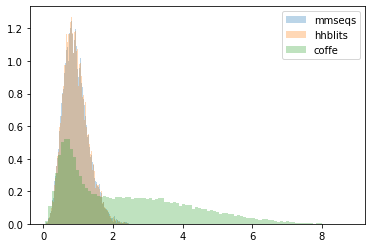

In [11]:
fig, ax = plt.subplots()
ax.hist(just_mmseqs_filtered['normalized bit score'], bins=100, label='mmseqs', alpha=0.3, density=True);
ax.hist(hhblits_filtered['normalized bit score'], bins=100, label='hhblits', alpha=0.3, density=True);
ax.hist(structural_annotation['normalized bit score'], bins=100, label='coffe', alpha=0.3, density=True);
ax.legend()

In [12]:
unique_up_id = pd.concat([hhblits_filtered['target'].drop_duplicates(),
                          just_mmseqs_filtered['target'].drop_duplicates()])
unique_up_id.drop_duplicates(inplace=True)

In [13]:
with open(f'../data/milot_unique_ids.txt', 'w') as tmp:
    ids_as_str = unique_up_id.astype(str).values
    tmp.write(','.join(ids_as_str))

<div class="alert alert-block alert-warning"><b>DISCLAIMER:</b> To make this cell execute, you may need to copy the contents of the UPIMAPI/resource folder into the main repository directory.</div>

In [42]:
!python /g/arendt/npapadop/repos/UPIMAPI/upimapi.py -i ../data/milot_unique_ids.txt -o ../data/ --fasta --no-annotation

2022-07-27 11:48:46: ID mapping has begun.
Auto determined "full id" as: False
../data/uniprotinfo.fasta not found. Will perform mapping for all IDs.
Checking which IDs are missing information.
Checking which IDs are missing information.: 100%|█| 24540/24540 [00:00<00:00, 3
Information already gathered for 0 ids. Still missing for 24540.
Building FASTA from 24540 IDs.
UniProt ID mapping:   0%|                                 | 0/3 [00:00<?, ?it/s]
Traceback (most recent call last):
  File "/g/arendt/npapadop/repos/UPIMAPI/upimapi.py", line 1130, in <module>
    upimapi()
  File "/g/arendt/npapadop/repos/UPIMAPI/upimapi.py", line 1125, in upimapi
    uniprot_fasta_workflow(ids, f'{args.output}/uniprotinfo.fasta', step=args.step, sleep_time=args.sleep)
  File "/g/arendt/npapadop/repos/UPIMAPI/upimapi.py", line 309, in uniprot_fasta_workflow
    uniprotinfo = get_uniprot_fasta(ids_missing, step=step, sleep_time=sleep_time)
  File "/g/arendt/npapadop/repos/UPIMAPI/upimapi.py", line 285, in